In [2]:
%matplotlib inline
#%matplotlib

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# para graficar distribución de características
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

#### Cargo y muestro la imagen de mi elección

In [3]:
img = cv.imread('Piezas.png')
#img = cv.imread('pastilla.jpg')

cv.namedWindow('Imagen original', cv.WINDOW_NORMAL)
cv.resizeWindow('Imagen original', 450, 450)
cv.imshow('Imagen original',img)
cv.waitKey(0)
cv.destroyAllWindows()
print('Imagen BGR',img.shape)

Imagen BGR (709, 793, 3)


#### 1) Construyo espacio de color (CIELab)

In [3]:
imgLab = cv.cvtColor(img, cv.COLOR_BGR2Lab)
# Tengo duda con la visualizacion
cv.namedWindow('Imagen CIELab', cv.WINDOW_NORMAL)
cv.resizeWindow('Imagen CIELab', 1000, 450)
cv.imshow('Imagen CIELab',imgLab)
cv.waitKey(0)
cv.destroyAllWindows()
print('Imagen CIELab',imgLab.shape)
#imgLab

Imagen CIELab (709, 793, 3)


#### 2) Construyo espacio de color y posición (Gray, x, y)

In [4]:
imgGray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
cv.namedWindow('Imagen Gray', cv.WINDOW_NORMAL)
cv.resizeWindow('Imagen Gray', 500, 500)
cv.imshow('Imagen Gray',imgGray)
cv.waitKey(0)
cv.destroyAllWindows()
print('Imagen Gray',imgGray.shape)

x = np.repeat(np.arange(1,imgGray.shape[1]+1,1).reshape(1,imgGray.shape[1]), imgGray.shape[0], axis = 0)
y = np.repeat(np.arange(1,imgGray.shape[0]+1,1).reshape(imgGray.shape[0],1), imgGray.shape[1], axis = 1)

imgGray_xy = np.stack((imgGray/255, x/x.max(), y/y.max()), axis = 2)
#imgGray_xy = np.stack((imgGray, x, y), axis = 2)
print('Imagen Gray y X-Y',imgGray_xy.shape)
imgGray_xy

Imagen Gray (709, 793)
Imagen Gray y X-Y (709, 793, 3)


array([[[0.28627451, 0.00126103, 0.00141044],
        [0.30196078, 0.00252207, 0.00141044],
        [0.29803922, 0.0037831 , 0.00141044],
        ...,
        [0.15294118, 0.99747793, 0.00141044],
        [0.14509804, 0.99873897, 0.00141044],
        [0.16078431, 1.        , 0.00141044]],

       [[0.28627451, 0.00126103, 0.00282087],
        [0.28627451, 0.00252207, 0.00282087],
        [0.29803922, 0.0037831 , 0.00282087],
        ...,
        [0.15686275, 0.99747793, 0.00282087],
        [0.14509804, 0.99873897, 0.00282087],
        [0.14509804, 1.        , 0.00282087]],

       [[0.29411765, 0.00126103, 0.00423131],
        [0.30196078, 0.00252207, 0.00423131],
        [0.28627451, 0.0037831 , 0.00423131],
        ...,
        [0.16078431, 0.99747793, 0.00423131],
        [0.12941176, 0.99873897, 0.00423131],
        [0.14901961, 1.        , 0.00423131]],

       ...,

       [[0.35686275, 0.00126103, 0.99717913],
        [0.36862745, 0.00252207, 0.99717913],
        [0.35686275, 0

#### 3)i) Grafico la distribución de características para CIELab

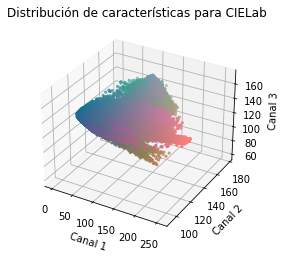

In [5]:
L, a, b = cv.split(imgLab)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

pixel_colors = imgLab.reshape((np.shape(imgLab)[0]*np.shape(imgLab)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(L.flatten(), a.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Canal 1", fontsize = 10)
axis.set_ylabel("Canal 2", fontsize = 10)
axis.set_zlabel("Canal 3", fontsize = 10)
axis.set_title("Distribución de características para CIELab", fontsize = 12)
plt.show()

#### 3)ii) Grafico la distribución de características para GRAY

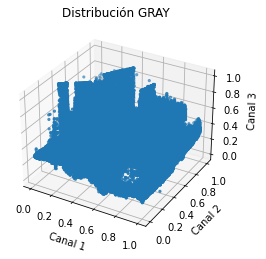

In [6]:
G, x, y = cv.split(imgGray_xy)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

#pixel_colors = imgGray_xy.reshape((np.shape(imgGray_xy)[0]*np.shape(imgGray_xy)[1], 3))
#norm = colors.Normalize(vmin=-1.,vmax=1.)
#norm.autoscale(pixel_colors)
#pixel_colors = norm(pixel_colors).tolist()


axis.scatter(x.flatten(), y.flatten(), G.flatten(), marker=".")# facecolors=pixel_colors, marker=".")

#axis.scatter(x.flatten(), y.flatten(), G.flatten(), cmap=plt.cm.gray, marker=".")#cmap=plt.get_cmap('gray'),vmin=0,vmax=255, marker=".")
axis.set_xlabel("Canal 1", fontsize = 10)
axis.set_ylabel("Canal 2", fontsize = 10)
axis.set_zlabel("Canal 3", fontsize = 10)
axis.set_title("Distribución GRAY", fontsize = 12)
plt.show()

#### 4)i) Imagen posterizada y máscaras para CIELab

In [7]:
# Cambiamos el tamaño a un array de Mx3 (con M el número de píxels). Es decir, un vector de M componentes por canal (R,G,B)
features = imgLab.reshape((-1,3))
print('Dimensión de la matriz de características (espacio CIELab): {}'.format(features.shape))
features = np.float32(features)

Dimensión de la matriz de características (espacio CIELab): (562237, 3)


In [8]:
# Criterio de detención (Epsilon e iteraciones máximas) y número de clústers (K)
criteria = (cv.TERM_CRITERIA_MAX_ITER + cv.TERM_CRITERIA_EPS, 10, 1.0)
K = 3

compact, label, color_clusters = cv.kmeans(features, K, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)

color_clusters = np.uint8(color_clusters)
print(f'Centroides: \n {color_clusters} \n')

compact = np.uint8(compact)
print('Compactación: \n {} \n'.format(compact))
label[:4]

Centroides: 
 [[167 129 148]
 [ 80 101 137]
 [ 85 156  96]] 

Compactación: 
 9 



array([[1],
       [1],
       [1],
       [1]], dtype=int32)

In [9]:
img_out = color_clusters[label.flatten()]
img_out = img_out.reshape((imgLab.shape))

cv.imshow('Imagen posterizada',img_out)
cv.waitKey(0)
cv.destroyAllWindows()

In [10]:
mask_list = list()
for cluster in color_clusters:
    mask = np.zeros(img_out.shape[:2],'uint8')
    mask[np.where((img_out == cluster).all(axis=2))] = 255
    mask_list.append(mask)

for i, mask in enumerate(mask_list):
    img_segmented = cv.bitwise_and(imgLab, imgLab, mask = mask)
    cv.imshow(f'mascara {i}', mask)
    cv.waitKey(0)
    cv.destroyAllWindows()

#### 4)ii) Imagen posterizada y máscaras para Gray y X-Y

In [15]:
# Cambiamos el tamaño a un array de Mx3 (con M el número de píxels). Es decir, un vector de M componentes por canal (R,G,B)
features = imgGray_xy.reshape((-1,3))
print('Dimensión de la matriz de características (espacio Gray XY): {}'.format(features.shape))
features = np.float32(features)
#features

Dimensión de la matriz de características (espacio Gray XY): (562237, 3)


In [16]:
# Criterio de detención (Epsilon e iteraciones máximas) y número de clústers (K)
criteria = (cv.TERM_CRITERIA_MAX_ITER + cv.TERM_CRITERIA_EPS, 10, 1.0)
K = 3

compact, label, color_clusters = cv.kmeans(features, K, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)

normaliz = np.array([255, x.max(), y.max()])
color_clusters = np.uint(color_clusters*normaliz)
print(f'Centroides: \n {color_clusters} \n')

compact = np.uint8(compact)
print('Compactación: \n {} \n'.format(compact))
label[:4]

Centroides: 
 [[106 261 472]
 [100 607 298]
 [ 64 161 142]] 

Compactación: 
 111 



array([[2],
       [2],
       [2],
       [2]], dtype=int32)

In [17]:
img_out = color_clusters[label.flatten()]

print(img_out.shape)
img_out = img_out.reshape((imgGray_xy.shape))
print(img_out.shape)

cv.imshow('Imagen posterizada',img_out[:,:,0])
cv.waitKey(0)
cv.destroyAllWindows()

(562237, 3)
(709, 793, 3)


error: OpenCV(4.5.2) ../modules/highgui/src/precomp.hpp:140: error: (-215:Assertion failed) src_depth != CV_16F && src_depth != CV_32S in function 'convertToShow'


In [14]:
img_out[:,:,0]

array([[ 78, 137, 137, ...,  78,  78,  78],
       [ 78,  78, 137, ...,  78,  78,  78],
       [137, 137,  78, ...,  78,  78,  78],
       ...,
       [137, 137, 137, ...,  86,  86,  86],
       [ 86, 137, 137, ...,  86,  86,  86],
       [137, 137, 137, ...,  86,  86,  86]], dtype=uint64)